# Choosing the Best Model

In the previous step, we looked at an attempt to predict the 2017 Tournament and examined the SVC model. Here, we will use the most recent year, 2023 to do our model experimentation. Because of that, we will use a more extensive [dataset folder](https://www.kaggle.com/competitions/march-machine-learning-mania-2023/data).

## Data Preparation and Feature Selection

We mill mainly use code from the 2017 [example from before](https://github.com/adeshpande3/March-Madness-2017) and adjust it to 2023.

In [934]:
import pandas as pd
import numpy as np
import collections

In [935]:
# Regular Season Results since 1985 (Only includes who won and the points)
reg_season_compact_pd = pd.read_csv('Data/MRegularSeasonCompactResults.csv') \

# Regular Season Results since 2003 but includes useful stats like Rebounds, Assists, etc.
reg_season_detailed_pd = pd.read_csv('Data/MRegularSeasonDetailedResults.csv')

# List of teams who are/was in Division I along with their ID
teams_pd = pd.read_csv('Data/MTeams.csv')

# Like the first two DataFrames but for the tournament
tourney_compact_pd = pd.read_csv('Data/MNCAATourneyCompactResults.csv')
tourney_detailed_pd = pd.read_csv('Data/MNCAATourneyDetailedResults.csv')

# The Conference Tourney Detailed Results since 2003
conference_tourney_results_pd = pd.read_csv('Data/MConferenceTourneyGames.csv')

# List of Teams along with their Conferences and ID per Year
conferences_pd = pd.read_csv('Data/MTeamConferences.csv')

# Seeds 
seeds_pd = pd.read_csv('Data/MNCAATourneySeeds.csv')

# List of Conference Tourney Winners since 2001
l = []
for i in range(len(conference_tourney_results_pd) - 1):
    if conference_tourney_results_pd.iloc[i, 1] != conference_tourney_results_pd.iloc[i + 1, 1]:
        season = conference_tourney_results_pd.iloc[i, 0]
        conference = conference_tourney_results_pd.iloc[i, 1]
        winner = conference_tourney_results_pd.iloc[i, 3]
        l.append({'Season': season, 'Conference': conference, 'Winner': winner})
        
conference_tourney_winners_pd = pd.DataFrame(l)

We will unfortunately not use a lot of the features presented last time, but we will use the following:

- Regular Season Wins
- Points per game season average
- Points per game allowed season average
- Whether or not in Power 6 conference (ACC, Big Ten, Big 12, SEC, Pac 12, Big East) - Binary label
- Number of 3's per game
- Turnovers per game average
- Assists per game average
- Conference Tournament Championship - binary label
- Tournament Seed
- Rebounds per game average
- Steals per game average
- Number of NCAA appearances since 1985

In [937]:
# Get ID given Name
def getTeamID(name):
    return teams_pd[teams_pd['TeamName'] == name].values[0][0]

# Get Name given ID
def getTeamName(team_id):
    return teams_pd[teams_pd['TeamID'] == team_id].values[0][1]

print("ID for Baylor is", getTeamID("Baylor"))
print("The team with ID 1124 is", getTeamName(1124))

ID for Baylor is 1124
The team with ID 1124 is Baylor


In [942]:
# How many wins did a Team win in a given Season
def getRegSeasonWins(team_id, year):
    c1 = reg_season_compact_pd['WTeamID'] == team_id
    c2 = reg_season_compact_pd['Season'] == year
    return len(reg_season_compact_pd[c1 & c2])

# What was a team's Points per Game in a given Season
def getPPG(team_id, year):
    ppg = 0
    c1 = reg_season_compact_pd['WTeamID'] == team_id
    c2 = reg_season_compact_pd['Season'] == year
    c3 = reg_season_compact_pd['LTeamID'] == team_id
    gamesWon = reg_season_compact_pd[c1 & c2]
    ppg = gamesWon['WScore'].sum()
    gamesLost = reg_season_compact_pd[c2 & c3]
    ppg += gamesLost['LScore'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    ppg /= total_games
    return round(ppg, 2)

# In a given season, how many points did a given team give up per game
def getOPPG(team_id, year):
    oppg = 0
    c1 = reg_season_compact_pd['WTeamID'] == team_id
    c2 = reg_season_compact_pd['Season'] == year
    c3 = reg_season_compact_pd['LTeamID'] == team_id
    gamesWon = reg_season_compact_pd[c1 & c2]
    oppg = gamesWon['LScore'].sum()
    gamesLost = reg_season_compact_pd[c2 & c3]
    oppg += gamesLost['WScore'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    oppg /= total_games
    return round(oppg, 2)

baylor_id = getTeamID("Baylor")
print("In 2022, Baylor won", getRegSeasonWins(baylor_id, 2022), "games.")
print("They averaged", getPPG(baylor_id, 2022), "points per game.")
print("While holding opponents to", getOPPG(baylor_id, 2022), "points per game.")

In 2022, Baylor won 26 games.
They averaged 76.5 points per game.
While holding opponents to 63.62 points per game.


In [944]:
# Hardcoded the divisions as of 2022
ACC = [1181, 1314, 1323, 1274, 1448, 1438, 1439, 1199, 1393, 1155, 1257, 1130, 1338, 1210, 1301]
Big12 = [1242, 1124, 1403, 1400, 1395, 1329, 1235, 1328, 1243, 1452]
BigEast = [1437, 1344, 1163, 1166, 1371, 1266, 1462, 1385, 1177, 1139, 1207]
Big10 = [1458, 1228, 1345, 1234, 1326, 1353, 1276, 1277, 1321, 1231, 1268, 1336, 1278, 1304]
Pac12 = [1112, 1113, 1417, 1425, 1160, 1450, 1449, 1332, 1333, 1143, 1390, 1428]
SEC = [1120, 1397, 1246, 1116, 1401, 1261, 1196, 1376, 1104, 1280, 1435, 1281, 1279, 1208]

# Quick function to check if a team's ID is in these lists
def getPower6(team_id):
    if team_id in ACC or team_id in Big12 or team_id in BigEast or team_id in Big10 or team_id in Pac12 or team_id in SEC:
        return 1
    else:
        return 0

if getPower6(getTeamID("BYU")):
    print("BYU is in a Power 6 conference.")
else:
    print("BYU is NOT in a Power 6 conference.")
    
if getPower6(getTeamID("Duke")):
    print("Duke is in a Power 6 conference.")
else:
    print("Duke is NOT in a Power 6 conference.")

BYU is NOT in a Power 6 conference.
Duke is in a Power 6 conference.


In [945]:
# How many three's did a team make per game in a given season
def get3PT(team_id, year):
    if year < 2003:
        return 0
    threes = 0
    c1 = reg_season_detailed_pd['WTeamID'] == team_id
    c2 = reg_season_detailed_pd['Season'] == year
    c3 = reg_season_detailed_pd['LTeamID'] == team_id
    gamesWon = reg_season_detailed_pd[c1 & c2]
    threes = gamesWon['WFGM3'].sum()
    gamesLost = reg_season_detailed_pd[c2 & c3]
    threes += gamesLost['LFGM3'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    threes /= total_games
    return round(threes, 2)

# How many turnovers did a team make per game in a given season
def getTO(team_id, year):
    if year < 2003:
        return 0
    to = 0
    c1 = reg_season_detailed_pd['WTeamID'] == team_id
    c2 = reg_season_detailed_pd['Season'] == year
    c3 = reg_season_detailed_pd['LTeamID'] == team_id
    gamesWon = reg_season_detailed_pd[c1 & c2]
    to = gamesWon['WTO'].sum()
    gamesLost = reg_season_detailed_pd[c2 & c3]
    to += gamesLost['LTO'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    to /= total_games
    return round(to, 2)

ETSU_id = getTeamID("ETSU")
print("In 2009, ETSU averaged", get3PT(ETSU_id, 2009), "threes per game.")
print("While committing", getTO(ETSU_id, 2009), "turnovers per game.")

In 2009, ETSU averaged 5.94 threes per game.
While committing 14.0 turnovers per game.


In [946]:
# How many Assists did a team make per game
def getAST(team_id, year):
    if year < 2003:
        return 0
    ast = 0
    c1 = reg_season_detailed_pd['WTeamID'] == team_id
    c2 = reg_season_detailed_pd['Season'] == year
    c3 = reg_season_detailed_pd['LTeamID'] == team_id
    gamesWon = reg_season_detailed_pd[c1 & c2]
    ast = gamesWon['WAst'].sum()
    gamesLost = reg_season_detailed_pd[c2 & c3]
    ast += gamesLost['LAst'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    ast /= total_games
    return round(ast, 2)

# Determine if a team was the conference champion in their division in a given year
def getTourneyConferenceChampion(team_id, year):
    if year < 2001:
        return 0
    conf = getConference(team_id, year)
    c1 = conference_tourney_winners_pd['Season'] == year
    c2 = conference_tourney_winners_pd['Conference'] == conf
    if len(conference_tourney_winners_pd[c1 & c2]) == 0:
        return 0
    if team_id == conference_tourney_winners_pd[c1 & c2]['Winner'].values[0]:
        return 1
    else:
        return 0

In [ ]:
# Easy way to get a team's conference in a given year
def getConference(team_id, year):
    c1 = conferences_pd['TeamID'] == team_id
    c2 = conferences_pd['Season'] == year
    c3 = conferences_pd[c1 & c2]
    if len(c3) == 0:
        return conferences_pd[c1].values[0][2]
    return c3['ConfAbbrev'].values[0]

# Get the seed of the team in a given year
def getSeed(team_id, year):
    c1 = seeds_pd['TeamID'] == team_id
    c2 = seeds_pd['Season'] == year
    if len(seeds_pd[c1 & c2]) == 0:
        return 0
    return int(seeds_pd[c1 & c2]['Seed'].values[0][1:3])

# Get rebounds per game in a given year
def getRPG(team_id, year):
    if year < 2003:
        return 0
    reb = 0
    c1 = reg_season_detailed_pd['WTeamID'] == team_id
    c2 = reg_season_detailed_pd['Season'] == year
    c3 = reg_season_detailed_pd['LTeamID'] == team_id
    gamesWon = reg_season_detailed_pd[c1 & c2]
    reb = gamesWon['WOR'].sum()
    reb += gamesWon['WDR'].sum()
    gamesLost = reg_season_detailed_pd[c2 & c3]
    reb += gamesLost['LOR'].sum()
    reb += gamesLost['LDR'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    reb /= total_games
    return round(reb, 2)

In [947]:
# Steals per game
def getSTL(team_id, year):
    if year < 2003:
        return 0
    stl = 0
    c1 = reg_season_detailed_pd['WTeamID'] == team_id
    c2 = reg_season_detailed_pd['Season'] == year
    c3 = reg_season_detailed_pd['LTeamID'] == team_id
    gamesWon = reg_season_detailed_pd[c1 & c2]
    stl = gamesWon['WStl'].sum()
    gamesLost = reg_season_detailed_pd[c2 & c3]
    stl += gamesLost['LStl'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    stl /= total_games
    return round(stl, 2)

# How many times did a team appear in the tournament as of 2022
def getNumOfAppearances(team_id):
    return len(seeds_pd[seeds_pd['TeamID'] == team_id])

# Helper function for below
def getHomeStat(row):
    if (row == 'H'):
        home = 1
    if (row == 'A'):
        home = -1
    if (row == 'N'):
        home = 0
    return home

In [948]:
# Build the vector
def getSeasonData(team_id, year):
    # Check first if the team was Division 1 at the time
    c1 = teams_pd[teams_pd['TeamID'] == team_id]['FirstD1Season'].values[0] <= year
    c2 = teams_pd[teams_pd['TeamID'] == team_id]['LastD1Season'].values[0] >= year
    if ~c1 or ~c2:
        return []
    return [getRegSeasonWins(team_id, year),
            getPPG(team_id, year),
            getOPPG(team_id, year),
            getPower6(team_id),
            get3PT(team_id, year),
            getTO(team_id, year),
            getAST(team_id, year),
            getTourneyConferenceChampion(team_id, year),
            getSeed(team_id, year),
            getRPG(team_id, year),
            getSTL(team_id, year),
            getNumOfAppearances(team_id)]

# Build vectors for every team in a given season
def createSeasonDict(year):
    seasonDictionary = collections.defaultdict(list)
    for team in teams_pd['TeamName'].tolist():
        team_id = teams_pd[teams_pd['TeamName'] == team].values[0][0]
        team_vector = getSeasonData(team_id, year)
        seasonDictionary[team_id] = team_vector
    return seasonDictionary

# Below is the season data for Toledo in 2013
getSeasonData(1405, 2013)

[15, 68.86, 68.25, 0, 5.93, 12.0, 13.04, 0, 0, 32.82, 7.04, 0]

In [949]:
# Basically run the function directly above this one on a set of years
def createTrainingSet(years):
    totalNumGames = 0
    for year in years:
        season = reg_season_compact_pd[reg_season_compact_pd['Season'] == year]
        totalNumGames += len(season.index)
        tourney = tourney_compact_pd[tourney_compact_pd['Season'] == year]
        totalNumGames += len(tourney.index)
    numFeatures = len(getSeasonData(1181,2012)) #Just choosing a random team and seeing the dimensionality of the vector
    xTrain = np.zeros(( totalNumGames, numFeatures + 1))
    yTrain = np.zeros(( totalNumGames ))
    indexCounter = 0
    for year in years:
        team_vectors = createSeasonDict(year)
        season = reg_season_compact_pd[reg_season_compact_pd['Season'] == year]
        numGamesInSeason = len(season.index)
        tourney = tourney_compact_pd[tourney_compact_pd['Season'] == year]
        numGamesInSeason += len(tourney.index)
        xTrainSeason = np.zeros(( numGamesInSeason, numFeatures + 1))
        yTrainSeason = np.zeros(( numGamesInSeason ))
        counter = 0
        for index, row in season.iterrows():
            w_team = row['WTeamID']
            w_vector = team_vectors[w_team]
            l_team = row['LTeamID']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = getHomeStat(row['WLoc'])
            if (counter % 2 == 0):
                diff.append(home) 
                xTrainSeason[counter] = diff
                yTrainSeason[counter] = 1
            else:
                diff.append(-home)
                xTrainSeason[counter] = [ -p for p in diff]
                yTrainSeason[counter] = 0
            counter += 1
        for index, row in tourney.iterrows():
            w_team = row['WTeamID']
            w_vector = team_vectors[w_team]
            l_team = row['LTeamID']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = 0 #All tournament games are neutral
            if (counter % 2 == 0):
                diff.append(home) 
                xTrainSeason[counter] = diff
                yTrainSeason[counter] = 1
            else:
                diff.append(-home)
                xTrainSeason[counter] = [ -p for p in diff]
                yTrainSeason[counter] = 0
            counter += 1
        xTrain[indexCounter:numGamesInSeason+indexCounter] = xTrainSeason
        yTrain[indexCounter:numGamesInSeason+indexCounter] = yTrainSeason
        indexCounter += numGamesInSeason
    return xTrain, yTrain

We will not use the entire dataset since we will be using lots of models, and that will be time consuming trying to fit those models (*cough* SVC *cough*). But we should still get a very good idea on how these models will fare for the newer data, and it should translate well historically. In Step 9 when we scale our dataset, we will use the entire dataset, but for now, we will use the previous year. 

In [950]:
# This will take a while
x_data, y_data = createTrainingSet([2022])
np.save('x_dataset', x_data)
np.save('y_dataset', y_data)

In [952]:
# Load it so we do not have to run it the above cell again
xTrain = np.load('x_dataset.npy')
yTrain = np.load('y_dataset.npy')
xTrain.shape

(5412, 13)

## Testing Various Models

Now we enter the point where we look into the various classification models in depth. We well all do hyperparamter tuning on them via `GridSearchCV()` to give everyone a fair shot. Finally, they will be put to the test to see who can predict the first round of the 2022 tournament the best.

In [953]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(xTrain, yTrain, test_size = .3, random_state = 942)

# We will store the model, training accuracy, and the tournament accuracy here
results = []

In [954]:
# Making the list of First Round Games
c1 = tourney_detailed_pd['DayNum'] == 136
c2 = tourney_detailed_pd['DayNum'] == 137
c3 = tourney_detailed_pd['Season'] == 2022
first_round_2022_pd = tourney_detailed_pd[(c1 | c2) & c3]

d = {'WTeamID': first_round_2022_pd['WTeamID'].tolist(),
     'LTeamID': first_round_2022_pd['LTeamID'].tolist()
    }

first_round_2022_prediction_pd = pd.DataFrame(d)
first_round_2022_prediction_pd.head()

,WTeamID,LTeamID
0,1116,1436
1,1124,1313
2,1166,1361
3,1211,1209
4,1242,1411


In [955]:
# Functions to predict probability that Team 1 wins given both teams and the model
def predictOutcome(w_data, l_data, model):
    diff = [a - b for a, b in zip(w_data, l_data)]
    diff.append(0)
    return model.predict_proba([diff])[0]

Furthermore, we will examine 5 games to help us choose our model for the next step. They are:

1) (1)Gonzaga vs. (16)Georgia St. where Gonzaga won pretty handily. (1211 vs. 1209)
2) (4)UCLA vs. (13)Akron where UCLA just barely survives. (1417 vs. 1103)
3) (8)North Carolina vs. (9)Marquette where North Carolina just completely dominates (1314 vs. 1266)
4) (11)Notre Dame vs. (6)Alabama where Notre Dame easily denies the Crimson Tide (1323 vs. 1104)
5) (15)St. Peter's vs. (2)Kentucky where St. Peter's pulls off the greatest upset this round. (1389 vs. 1246)

### SVC

In [956]:
from sklearn.svm import SVC

According to the research paper from last step, the Linear SVC gave the best accuracy. Let us see how it stands the test of time. Unfortunately, this will take a while to run, and afterwards doing some hyperparamter tuning... pass.

#### Linear SVC

In [957]:
# Step 1: Build the model and examine accuracy score
model_SVC_linear = SVC(kernel = 'linear')
model_SVC_linear = model_SVC_linear.fit(X_train, y_train)
y_pred_SVC_linear = model_SVC_linear.predict(X_test)

print(classification_report(y_test, y_pred_SVC_linear))
model_SVC_accuracy_linear = accuracy_score(y_test, y_pred_SVC_linear)
model_SVC_accuracy_linear = round(model_SVC_accuracy_linear, 4)

# We will store this later
model_SVC_accuracy_linear

              precision    recall  f1-score   support

         0.0       0.73      0.76      0.74       791
         1.0       0.76      0.73      0.74       833

    accuracy                           0.74      1624
   macro avg       0.74      0.74      0.74      1624
weighted avg       0.74      0.74      0.74      1624



0.742

In [958]:
# Step 2: Create list of probabilities that Team 1 would win

# First copy the dataframe made earlier
model_SVC_linear_prediction_pd = first_round_2022_prediction_pd.copy()

probabilities = []

# We will use these for the SVC models only
from sklearn.calibration import CalibratedClassifierCV
cc_linear = CalibratedClassifierCV(model_SVC_linear)
cc_linear.fit(X_train, y_train)

for i in range(len(model_SVC_linear_prediction_pd)):
    w_team = model_SVC_linear_prediction_pd.iloc[i, 0]
    l_team = model_SVC_linear_prediction_pd.iloc[i, 1]
    w_data = getSeasonData(w_team, 2022)
    l_data = getSeasonData(l_team, 2022)
    prob = predictOutcome(w_data, l_data, cc_linear)
    probabilities.append(prob)

In [961]:
# Step 3: Add them to the copied dataframe and examine it
probabilites = np.array(probabilities)
model_SVC_linear_prediction_pd['Linear_SVC_Probabilities'] = probabilites[:, 1]
model_SVC_linear_prediction_pd['Linear_SVC_Probabilities'].describe()

count    32.000000
mean      0.674535
std       0.272790
min       0.034972
25%       0.506967
50%       0.727449
75%       0.919946
max       0.978470
Name: Linear_SVC_Probabilities, dtype: float64

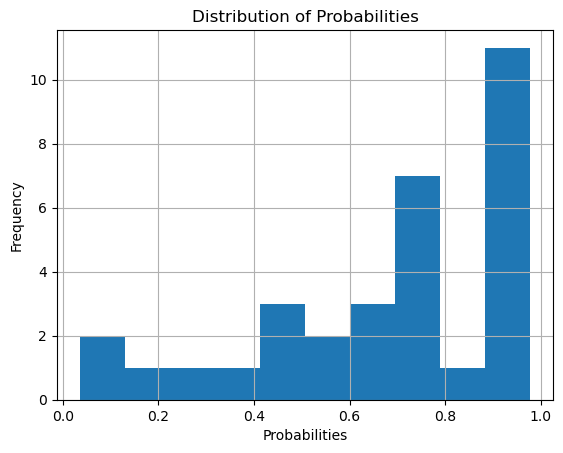

Accuracy for Predicting Round 1 is: 0.75


In [962]:
# Step 4: Plot the distribution
import matplotlib.pyplot as plt
%matplotlib inline

model_SVC_linear_prediction_pd['Linear_SVC_Probabilities'].hist(bins = 10)
plt.xlabel("Probabilities")
plt.ylabel("Frequency")
plt.title("Distribution of Probabilities")
plt.show()
model_SVC_accuracy_linear_tournament = len(model_SVC_linear_prediction_pd[model_SVC_linear_prediction_pd['Linear_SVC_Probabilities'] >= .5]) / 32
print("Accuracy for Predicting Round 1 is:", model_SVC_accuracy_linear_tournament)

In [731]:
# Step 5: Examine the selected games
print("Gonzaga vs. Georgia St. Prediction:", model_SVC_linear_prediction_pd.iloc[3, 2])
print("UCLA vs. Akron Prediction:", model_SVC_linear_prediction_pd.iloc[15, 2])
print("North Carolina vs. Marquette:", model_SVC_linear_prediction_pd.iloc[9, 2])
print("Notre Dame vs. Alabama:", model_SVC_linear_prediction_pd.iloc[24, 2])
print("St. Peter's vs. Kentucky:", model_SVC_linear_prediction_pd.iloc[13, 2])

Gonzaga vs. Georgia St. Prediction: 0.9256836804285434
UCLA vs. Akron Prediction: 0.9180336819628374
North Carolina vs. Marquette: 0.733227431912017
Notre Dame vs. Alabama: 0.6255782369476646
St. Peter's vs. Kentucky: 0.03497230919533634


In [963]:
# Step 6: Add to results and make conclusions.
results.append({'Name': 'Linear_SVC',
                'Training_Acc': model_SVC_accuracy_linear,
                'Tournament_Acc': model_SVC_accuracy_linear_tournament
               })

It seems like the Linear SVC displayed a 74.2% accuracy on the training data. But when it came to the Tournament data, it scored a benchmark 75% accuracy. The lowest accuracy recorded was 3.497% which came from St. Peter's vs. Kentucky. The model also correctly predicted the 4 games shown just above including the upset by Notre Dame. All in all, if it were not for the runtime of SVC's we would go with them 100%.

#### Radial

In [964]:
model_SVC_rbf = SVC(kernel = 'rbf')
model_SVC_rbf = model_SVC_rbf.fit(X_train, y_train)
y_pred_SVC_rbf = model_SVC_rbf.predict(X_test)

print(classification_report(y_test, y_pred_SVC_rbf))
model_SVC_accuracy_rbf = accuracy_score(y_test, y_pred_SVC_rbf)
model_SVC_accuracy_rbf = round(model_SVC_accuracy_rbf, 4)
model_SVC_accuracy_rbf

              precision    recall  f1-score   support

         0.0       0.73      0.76      0.75       791
         1.0       0.76      0.73      0.75       833

    accuracy                           0.75      1624
   macro avg       0.75      0.75      0.75      1624
weighted avg       0.75      0.75      0.75      1624



0.7451

In [965]:
model_SVC_rbf_prediction_pd = first_round_2022_prediction_pd.copy()

probabilities = []

cc_rbf = CalibratedClassifierCV(model_SVC_rbf)
cc_rbf.fit(X_train, y_train)

for i in range(len(model_SVC_rbf_prediction_pd)):
    w_team = model_SVC_rbf_prediction_pd.iloc[i, 0]
    l_team = model_SVC_rbf_prediction_pd.iloc[i, 1]
    w_data = getSeasonData(w_team, 2022)
    l_data = getSeasonData(l_team, 2022)
    prob = predictOutcome(w_data, l_data, cc_rbf)
    probabilities.append(prob)

In [966]:
probabilites = np.array(probabilities)
model_SVC_rbf_prediction_pd['Radial_SVC_Probabilities'] = probabilites[:, 1]
model_SVC_rbf_prediction_pd['Radial_SVC_Probabilities'].describe()

count    32.000000
mean      0.631059
std       0.203303
min       0.202225
25%       0.422035
50%       0.736533
75%       0.791780
max       0.873147
Name: Radial_SVC_Probabilities, dtype: float64

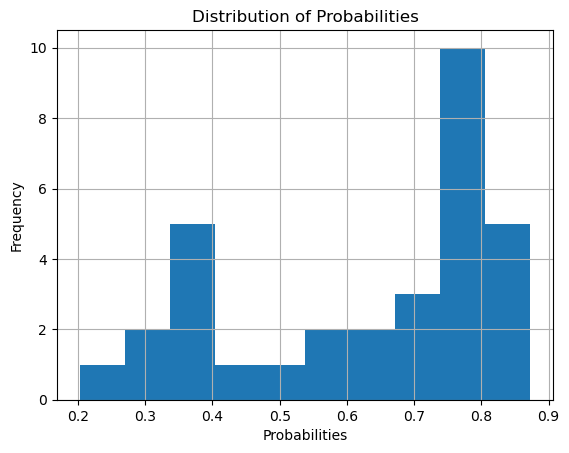

Accuracy for Predicting Round 1 is: 0.6875


In [967]:
model_SVC_rbf_prediction_pd['Radial_SVC_Probabilities'].hist(bins = 10)
plt.xlabel("Probabilities")
plt.ylabel("Frequency")
plt.title("Distribution of Probabilities")
plt.show()
model_SVC_accuracy_rbf_tournament = len(model_SVC_rbf_prediction_pd[model_SVC_rbf_prediction_pd['Radial_SVC_Probabilities'] >= .5]) / 32
print("Accuracy for Predicting Round 1 is:", model_SVC_accuracy_rbf_tournament)

In [968]:
print("Gonzaga vs. Georgia St. Prediction:", model_SVC_rbf_prediction_pd.iloc[3, 2])
print("UCLA vs. Akron Prediction:", model_SVC_rbf_prediction_pd.iloc[15, 2])
print("North Carolina vs. Marquette:", model_SVC_rbf_prediction_pd.iloc[9, 2])
print("Notre Dame vs. Alabama:", model_SVC_rbf_prediction_pd.iloc[24, 2])
print("St. Peter's vs. Kentucky:", model_SVC_rbf_prediction_pd.iloc[13, 2])

Gonzaga vs. Georgia St. Prediction: 0.7357289541652939
UCLA vs. Akron Prediction: 0.8206063842196869
North Carolina vs. Marquette: 0.805882675989535
Notre Dame vs. Alabama: 0.7428491064723785
St. Peter's vs. Kentucky: 0.3236485942620432


In [969]:
results.append({'Name': 'Radial_SVC',
                'Training_Acc': model_SVC_accuracy_rbf, 
                'Tournament_Acc': model_SVC_accuracy_rbf_tournament
               })

Despite having a slightly higher training accuracy than its linear counterpart, it did very poorly on predicting the tournament with a 68.75% accuracy. The most suprising thing, however is that it gave St. Peter's a 32.36% chance to beat Kentucky. Although we will not use this model, it was still a very good effort.

#### Varying Degree 

In [970]:
from sklearn.model_selection import GridSearchCV

param_grid_SVC_poly = {'degree': [0, 2, 3, 4]}
grid_SVC_poly = GridSearchCV(SVC(kernel = 'poly'), param_grid = param_grid_SVC_poly, cv = 3, n_jobs = -1)
grid_SVC_poly = grid_SVC_poly.fit(X_train, y_train)
print("Best: %f using %s" % (grid_SVC_poly.best_score_, grid_SVC_poly.best_params_))

Best: 0.738912 using {'degree': 3}


In [971]:
model_SVC_deg3 = SVC(kernel = 'poly', degree = 3)
model_SVC_deg3 = model_SVC_deg3.fit(X_train, y_train)
y_pred_SVC_deg3 = model_SVC_deg3.predict(X_test)

print(classification_report(y_test, y_pred_SVC_deg3))
model_SVC_accuracy_deg3 = accuracy_score(y_test, y_pred_SVC_deg3)
model_SVC_accuracy_deg3 = round(model_SVC_accuracy_rbf, 4)
model_SVC_accuracy_deg3

              precision    recall  f1-score   support

         0.0       0.73      0.77      0.75       791
         1.0       0.77      0.73      0.75       833

    accuracy                           0.75      1624
   macro avg       0.75      0.75      0.75      1624
weighted avg       0.75      0.75      0.75      1624



0.7451

In [972]:
model_SVC_deg3_prediction_pd = first_round_2022_prediction_pd.copy()

probabilities = []

cc_deg3 = CalibratedClassifierCV(model_SVC_deg3)
cc_deg3.fit(X_train, y_train)

for i in range(len(model_SVC_deg3_prediction_pd)):
    w_team = model_SVC_deg3_prediction_pd.iloc[i, 0]
    l_team = model_SVC_deg3_prediction_pd.iloc[i, 1]
    w_data = getSeasonData(w_team, 2022)
    l_data = getSeasonData(l_team, 2022)
    prob = predictOutcome(w_data, l_data, cc_deg3)
    probabilities.append(prob)

In [973]:
probabilites = np.array(probabilities)
model_SVC_deg3_prediction_pd['Degree3_SVC_Probabilities'] = probabilites[:, 1]
model_SVC_deg3_prediction_pd['Degree3_SVC_Probabilities'].describe()

count    32.000000
mean      0.664924
std       0.236200
min       0.099157
25%       0.457032
50%       0.659261
75%       0.875955
max       0.998751
Name: Degree3_SVC_Probabilites, dtype: float64

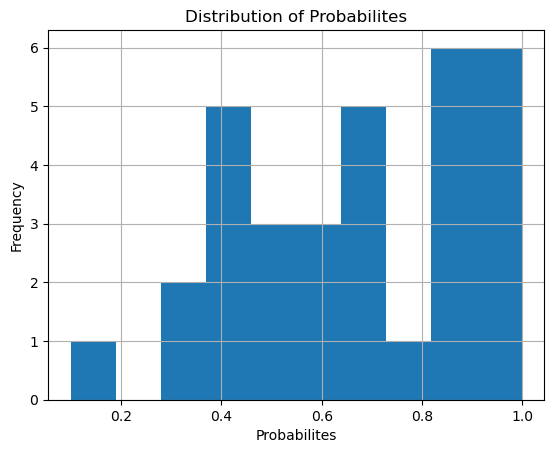

Accuracy for Predicting Round 1 is: 0.6875


In [753]:
model_SVC_deg3_prediction_pd['Degree3_SVC_Probabilities'].hist(bins = 10)
plt.xlabel("Probabilities")
plt.ylabel("Frequency")
plt.title("Distribution of Probabilities")
plt.show()
model_SVC_accuracy_deg3_tournament = len(model_SVC_deg3_prediction_pd[model_SVC_deg3_prediction_pd['Degree3_SVC_Probabilities'] >= .5]) / 32
print("Accuracy for Predicting Round 1 is:", model_SVC_accuracy_deg3_tournament)

In [974]:
print("Gonzaga vs. Georgia St. Prediction:", model_SVC_deg3_prediction_pd.iloc[3, 2])
print("UCLA vs. Akron Prediction:", model_SVC_deg3_prediction_pd.iloc[15, 2])
print("North Carolina vs. Marquette:", model_SVC_deg3_prediction_pd.iloc[9, 2])
print("Notre Dame vs. Alabama:", model_SVC_deg3_prediction_pd.iloc[24, 2])
print("St. Peter's vs. Kentucky:", model_SVC_deg3_prediction_pd.iloc[13, 2])

Gonzaga vs. Georgia St. Prediction: 0.9925521548604805
UCLA vs. Akron Prediction: 0.8673933876868498
North Carolina vs. Marquette: 0.6300594400193097
Notre Dame vs. Alabama: 0.6599729313302045
St. Peter's vs. Kentucky: 0.09915663921182566


In [975]:
results.append({'Name': 'Degree3_SVC',
                'Training_Acc': model_SVC_accuracy_deg3, 
                'Tournament_Acc': model_SVC_accuracy_deg3_tournament
               })

Like the Radial Kernel, it boasts a respectful training accuracy, but has the same tournament accuracy. Like the linear kernel, it did not expect St. Peter's to upset while also predicting with very high chances that UCLA would win. 

### Logistic Regression

In [976]:
from sklearn.linear_model import LogisticRegression

Unlike SVC, `GridSearchCV` will not take forever.

#### Default Parameters

In [761]:
model_logreg = LogisticRegression()
model_logreg = model_logreg.fit(X_train, y_train)
y_pred_logreg = model_logreg.predict(X_test)

print(classification_report(y_test, y_pred_logreg))
model_logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
model_logreg_accuracy

              precision    recall  f1-score   support

         0.0       0.74      0.75      0.75       791
         1.0       0.76      0.74      0.75       833

    accuracy                           0.75      1624
   macro avg       0.75      0.75      0.75      1624
weighted avg       0.75      0.75      0.75      1624



0.7487684729064039

In [977]:
model_logreg_prediction_pd = first_round_2022_prediction_pd.copy()

probabilities = []

for i in range(len(model_logreg_prediction_pd)):
    w_team = model_logreg_prediction_pd.iloc[i, 0]
    l_team = model_logreg_prediction_pd.iloc[i, 1]
    w_data = getSeasonData(w_team, 2022)
    l_data = getSeasonData(l_team, 2022)
    prob = predictOutcome(w_data, l_data, model_logreg)
    probabilities.append(prob)

In [981]:
probabilites = np.array(probabilities)
model_logreg_prediction_pd['LogReg_Probabilities'] = probabilites[:, 1]
model_logreg_prediction_pd['LogReg_Probabilities'].describe()

count    32.000000
mean      0.681566
std       0.280324
min       0.029835
25%       0.514691
50%       0.745162
75%       0.929867
max       0.984415
Name: LogReg_Probabilities, dtype: float64

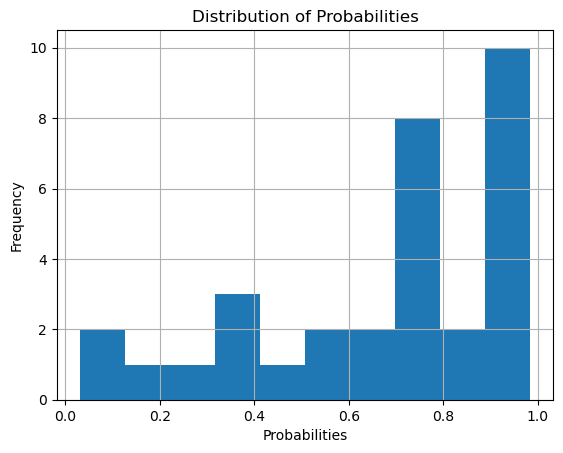

Accuracy for Predicting Round 1 is: 0.75


In [982]:
model_logreg_prediction_pd['LogReg_Probabilities'].hist(bins = 10)
plt.xlabel("Probabilities")
plt.ylabel("Frequency")
plt.title("Distribution of Probabilities")
plt.show()
model_logreg_accuracy_tournament = len(model_logreg_prediction_pd[model_logreg_prediction_pd['LogReg_Probabilities'] >= .5]) / 32
print("Accuracy for Predicting Round 1 is:", model_logreg_accuracy_tournament)

In [983]:
print("Gonzaga vs. Georgia St. Prediction:", model_logreg_prediction_pd.iloc[3, 2])
print("UCLA vs. Akron Prediction:", model_logreg_prediction_pd.iloc[15, 2])
print("North Carolina vs. Marquette:", model_logreg_prediction_pd.iloc[9, 2])
print("Notre Dame vs. Alabama:", model_logreg_prediction_pd.iloc[24, 2])
print("St. Peter's vs. Kentucky:", model_logreg_prediction_pd.iloc[13, 2])

Gonzaga vs. Georgia St. Prediction: 0.9329235137432769
UCLA vs. Akron Prediction: 0.9287667111082085
North Carolina vs. Marquette: 0.7444060270444116
Notre Dame vs. Alabama: 0.6150840267777412
St. Peter's vs. Kentucky: 0.029834833500692888


In [984]:
results.append({'Name': 'Logistic_Regression',
                'Training_Acc': model_logreg_accuracy, 
                'Tournament_Acc': model_logreg_accuracy_tournament
               })

The histogram shown above is very similar to the radial kernel, but once again fails to predict St. Peter's winning with a measly 3% percent. However, it did predict a 75% accuracy rate in the tournament data with a lot of 90% confidence probabilities. Maybe Logistic Regression is too confident in their picks.

#### Hyperparameter Tuned

In [985]:
params_logreg = {'penalty': [None, 'l1', 'l2'],
                 'dual': [True, False],
                 'tol': [.001, .01, .1, 1, 10, 100],
                 'C': [.001, .01, .1, 1, 10, 100],
                 'fit_intercept': [True, False]
                 }

grid_logreg = GridSearchCV(LogisticRegression(), param_grid = params_logreg, n_jobs = -1, cv = 5)
grid_logreg = grid_logreg.fit(X_train, y_train)
print("Best: %f using %s" % (grid_logreg.best_score_, grid_logreg.best_params_))

/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklea

/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklea

/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklea

/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklea

/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklea

Best: 0.749738 using {'C': 0.001, 'dual': False, 'fit_intercept': True, 'penalty': 'l2', 'tol': 100}


In [986]:
y_pred_logreg_grid = grid_logreg.predict(X_test)

print(classification_report(y_test, y_pred_logreg_grid))
model_logreg_accuracy_grid = accuracy_score(y_test, y_pred_logreg_grid)
model_logreg_accuracy_grid

              precision    recall  f1-score   support

         0.0       0.73      0.75      0.74       791
         1.0       0.76      0.74      0.75       833

    accuracy                           0.74      1624
   macro avg       0.74      0.74      0.74      1624
weighted avg       0.74      0.74      0.74      1624



0.7438423645320197

In [987]:
model_grid_logreg_prediction_pd = first_round_2022_prediction_pd.copy()

probabilities = []

for i in range(len(model_grid_logreg_prediction_pd)):
    w_team = model_grid_logreg_prediction_pd.iloc[i, 0]
    l_team = model_grid_logreg_prediction_pd.iloc[i, 1]
    w_data = getSeasonData(w_team, 2022)
    l_data = getSeasonData(l_team, 2022)
    prob = predictOutcome(w_data, l_data, grid_logreg)
    probabilities.append(prob)

In [988]:
probabilites = np.array(probabilities)
model_grid_logreg_prediction_pd['Grid_LogReg_Probabilities'] = probabilites[:, 1]
model_grid_logreg_prediction_pd['Grid_LogReg_Probabilities'].describe()

count    32.000000
mean      0.623574
std       0.238004
min       0.069938
25%       0.442234
50%       0.626679
75%       0.817988
max       0.964116
Name: Grid_LogReg_Probabilities, dtype: float64

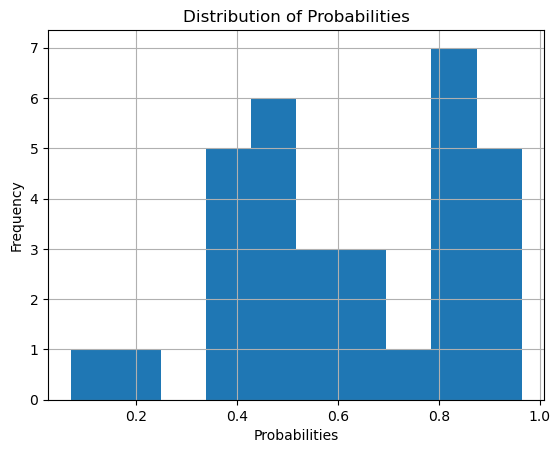

Accuracy for Predicting Round 1 is: 0.65625


In [992]:
model_grid_logreg_prediction_pd['Grid_LogReg_Probabilities'].hist(bins = 10)
plt.xlabel("Probabilities")
plt.ylabel("Frequency")
plt.title("Distribution of Probabilities")
plt.show()
model_grid_logreg_accuracy_tournament = len(model_grid_logreg_prediction_pd[model_grid_logreg_prediction_pd['Grid_LogReg_Probabilities'] >= .5]) / 32
print("Accuracy for Predicting Round 1 is:", model_grid_logreg_accuracy_tournament)

In [993]:
print("Gonzaga vs. Georgia St. Prediction:", model_grid_logreg_prediction_pd.iloc[3, 2])
print("UCLA vs. Akron Prediction:", model_grid_logreg_prediction_pd.iloc[15, 2])
print("North Carolina vs. Marquette:", model_grid_logreg_prediction_pd.iloc[9, 2])
print("Notre Dame vs. Alabama:", model_grid_logreg_prediction_pd.iloc[24, 2])
print("St. Peter's vs. Kentucky:", model_grid_logreg_prediction_pd.iloc[13, 2])

Gonzaga vs. Georgia St. Prediction: 0.956976319976059
UCLA vs. Akron Prediction: 0.8473478639845353
North Carolina vs. Marquette: 0.7859891478829071
Notre Dame vs. Alabama: 0.6012375903938659
St. Peter's vs. Kentucky: 0.06993826632170393


In [994]:
results.append({'Name': 'Logistic_Regression_HTuned',
                'Training_Acc': model_logreg_accuracy_grid, 
                'Tournament_Acc': model_grid_logreg_accuracy_tournament
               })

Ironically, hyperparameter tuning was worse than the default. It had a lower mean percentage of probabilities and worst off all, a worse tournament prediction accuracy. This could be since we did not choose every hyperparamter, but we still chose a lot. Things be weird.

### KNN

In [995]:
from sklearn.neighbors import KNeighborsClassifier

In theory, KNN would be the best model for predicting March Madness. The only problem is, you would have to find the best *n* or keep changing *n* to optimize results. We can start with the best *n* with default parameters.

#### The Best N

In [996]:
# We will use AUC and ROC curve to pick out the best N. Again, will take a while
from sklearn.metrics import roc_curve, auc

ns = list(range(25, 300))
n_result = []
for n in ns:
    model = KNeighborsClassifier(n_neighbors = n)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    n_result.append(roc_auc)

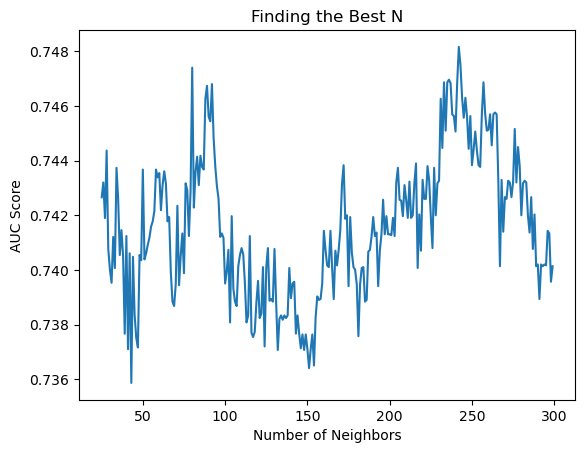

Best Accuracy: 0.7481647526267143 at N = 242


In [997]:
plt.plot(ns, n_result)
plt.xlabel("Number of Neighbors")
plt.ylabel("AUC Score")
plt.title("Finding the Best N")
plt.show()
# Because Index 0 is n = 25, Index 1 is n = 26, and so forth
print("Best Accuracy:", max(n_result), "at N =", n_result.index(max(n_result)) + 25)

In [998]:
model_knn242 = KNeighborsClassifier(242)
model_knn242 = model_knn242.fit(X_train, y_train)
y_pred_knn242 = model_knn242.predict(X_test)

print(classification_report(y_test, y_pred_knn242))
model_knn242_accuracy = accuracy_score(y_test, y_pred_knn242)
model_knn242_accuracy

              precision    recall  f1-score   support

         0.0       0.73      0.77      0.75       791
         1.0       0.77      0.72      0.75       833

    accuracy                           0.75      1624
   macro avg       0.75      0.75      0.75      1624
weighted avg       0.75      0.75      0.75      1624



0.7475369458128078

In [999]:
model_knn242_prediction_pd = first_round_2022_prediction_pd.copy()

probabilities = []

for i in range(len(model_knn242_prediction_pd)):
    w_team = model_knn242_prediction_pd.iloc[i, 0]
    l_team = model_knn242_prediction_pd.iloc[i, 1]
    w_data = getSeasonData(w_team, 2022)
    l_data = getSeasonData(l_team, 2022)
    prob = predictOutcome(w_data, l_data, model_knn242)
    probabilities.append(prob)

In [1000]:
probabilites = np.array(probabilities)
model_knn242_prediction_pd['KNN242_Probabilities'] = probabilites[:, 1]
model_knn242_prediction_pd['KNN242_Probabilities'].describe()

count    32.000000
mean      0.580708
std       0.183861
min       0.210744
25%       0.429752
50%       0.597107
75%       0.716942
max       0.863636
Name: KNN242_Probabilities, dtype: float64

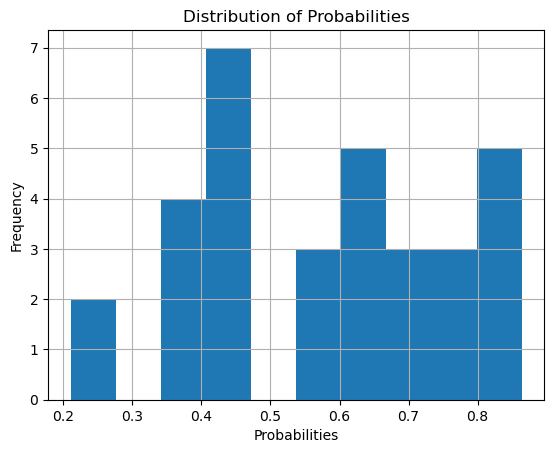

Accuracy for Predicting Round 1 is: 0.59375


In [1001]:
model_knn242_prediction_pd['KNN242_Probabilities'].hist(bins = 10)
plt.xlabel("Probabilities")
plt.ylabel("Frequency")
plt.title("Distribution of Probabilities")
plt.show()
model_knn242_accuracy_tournament = len(model_knn242_prediction_pd[model_knn242_prediction_pd['KNN242_Probabilities'] >= .5]) / 32
print("Accuracy for Predicting Round 1 is:", model_knn242_accuracy_tournament)

In [1002]:
print("Gonzaga vs. Georgia St. Prediction:", model_knn242_prediction_pd.iloc[3, 2])
print("UCLA vs. Akron Prediction:", model_knn242_prediction_pd.iloc[15, 2])
print("North Carolina vs. Marquette:", model_knn242_prediction_pd.iloc[9, 2])
print("Notre Dame vs. Alabama:", model_knn242_prediction_pd.iloc[24, 2])
print("St. Peter's vs. Kentucky:", model_knn242_prediction_pd.iloc[13, 2])

Gonzaga vs. Georgia St. Prediction: 0.8471074380165289
UCLA vs. Akron Prediction: 0.7644628099173554
North Carolina vs. Marquette: 0.7396694214876033
Notre Dame vs. Alabama: 0.5537190082644629
St. Peter's vs. Kentucky: 0.21074380165289255


In [1003]:
results.append({'Name': 'KNN242',
                'Training_Acc': model_knn242_accuracy, 
                'Tournament_Acc': model_knn242_accuracy_tournament
               })

The worst performer on the tourney analysis so far with a sub 60% accuracy. It did not make up for the fact that it still could not predict St. Peter's upset, so this is definitely out of the picture. Or we can try tuning it a little.

#### With Some Tuning

I would like to note that running the cell directly below this one will give different results each time it is run. If we were to choose this as our prototype, we will run this exact cell and roll with it.

In [1005]:
# Because GridSearchCV is so slow
from sklearn.model_selection import RandomizedSearchCV
                  
params_knn_best = {'n_neighbors': list(range(1, 300)),
                 'weights': ['uniform', 'distance'],
                 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                 'leaf_size': [10, 20, 30, 50, 100, 200],
                 'p': [1, 2, 3, 4]}

random_knn_best = RandomizedSearchCV(KNeighborsClassifier(), param_distributions = params_knn242, n_jobs = -1, cv = 5)
random_knn_best = grid_knn242.fit(X_train, y_train)
print("Best: %f using %s" % (grid_knn242.best_score_, grid_knn242.best_params_))

Best: 0.747889 using {'weights': 'uniform', 'p': 1, 'n_neighbors': 361, 'leaf_size': 15, 'algorithm': 'brute'}


In [1006]:
y_pred_knn_random = random_knn_best.predict(X_test)

print(classification_report(y_test, y_pred_knn_random))
model_knn_accuracy_random = accuracy_score(y_test, y_pred_logreg_grid)
model_knn_accuracy_random

              precision    recall  f1-score   support

         0.0       0.73      0.76      0.74       791
         1.0       0.76      0.73      0.74       833

    accuracy                           0.74      1624
   macro avg       0.74      0.74      0.74      1624
weighted avg       0.74      0.74      0.74      1624



0.7438423645320197

In [1007]:
model_random_knn_prediction_pd = first_round_2022_prediction_pd.copy()

probabilities = []

for i in range(len(model_random_knn_prediction_pd)):
    w_team = model_random_knn_prediction_pd.iloc[i, 0]
    l_team = model_random_knn_prediction_pd.iloc[i, 1]
    w_data = getSeasonData(w_team, 2022)
    l_data = getSeasonData(l_team, 2022)
    prob = predictOutcome(w_data, l_data, random_knn_best)
    probabilities.append(prob)

In [1011]:
probabilites = np.array(probabilities)
model_random_knn_prediction_pd['KNN_Best_Probabilities'] = probabilites[:, 1]
model_random_knn_prediction_pd['KNN_Best_Probabilities'].describe()

count    32.000000
mean      0.571330
std       0.176863
min       0.182825
25%       0.423823
50%       0.560942
75%       0.725069
max       0.847645
Name: KNN_Best_Probabilities, dtype: float64

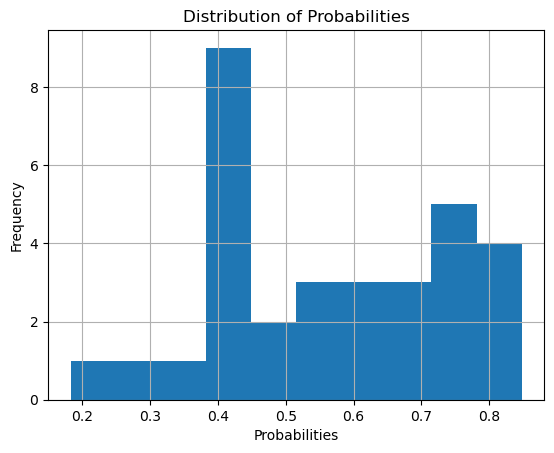

Accuracy for Predicting Round 1 is: 0.59375


In [1012]:
model_random_knn_prediction_pd['KNN_Best_Probabilities'].hist(bins = 10)
plt.xlabel("Probabilities")
plt.ylabel("Frequency")
plt.title("Distribution of Probabilities")
plt.show()
model_random_knn_accuracy_tournament = len(model_random_knn_prediction_pd[model_random_knn_prediction_pd['KNN_Best_Probabilities'] >= .5]) / 32
print("Accuracy for Predicting Round 1 is:", model_random_knn_accuracy_tournament)

In [1013]:
print("Gonzaga vs. Georgia St. Prediction:", model_random_knn_prediction_pd.iloc[3, 2])
print("UCLA vs. Akron Prediction:", model_random_knn_prediction_pd.iloc[15, 2])
print("North Carolina vs. Marquette:", model_random_knn_prediction_pd.iloc[9, 2])
print("Notre Dame vs. Alabama:", model_random_knn_prediction_pd.iloc[24, 2])
print("St. Peter's vs. Kentucky:", model_random_knn_prediction_pd.iloc[13, 2])

Gonzaga vs. Georgia St. Prediction: 0.8476454293628809
UCLA vs. Akron Prediction: 0.7313019390581718
North Carolina vs. Marquette: 0.7063711911357341
Notre Dame vs. Alabama: 0.5844875346260388
St. Peter's vs. Kentucky: 0.18282548476454294


In [1014]:
results.append({'Name': 'KNN_Best',
                'Training_Acc': model_knn_accuracy_random, 
                'Tournament_Acc': model_random_knn_accuracy_tournament
               })

Well, not much different to N = 242, so yeah...

###  XGBoost

In [1015]:
import xgboost as xgb

Finally we will look at XGBoost, one of the main Boosting techniques. Because Decision Trees and Random Forest do really bad for this type of problem, it is not worth looking at. There will also be no need to hyperparameter tune.

In [1016]:
model_xgb = xgb.XGBClassifier(seed = 1424, nthread = 1)
model_xgb = model_xgb.fit(X_train, y_train, verbose = 10)

y_pred_xgb = model_xgb.predict(X_test)
model_xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(classification_report(y_test, y_pred_xgb))
print("Test error: {:.3f}".format(1 - model_xgb_accuracy))

[23:58:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.69      0.70      0.69       791
         1.0       0.71      0.70      0.70       833

    accuracy                           0.70      1624
   macro avg       0.70      0.70      0.70      1624
weighted avg       0.70      0.70      0.70      1624

Test error: 0.301


In [1017]:
model_xgb_prediction_pd = first_round_2022_prediction_pd.copy()

probabilities = []

for i in range(len(model_xgb_prediction_pd)):
    w_team = model_xgb_prediction_pd.iloc[i, 0]
    l_team = model_xgb_prediction_pd.iloc[i, 1]
    w_data = getSeasonData(w_team, 2022)
    l_data = getSeasonData(l_team, 2022)
    prob = predictOutcome(w_data, l_data, model_xgb)
    probabilities.append(prob)

In [1018]:
probabilites = np.array(probabilities)
model_xgb_prediction_pd['XGB_Probabilities'] = probabilites[:, 1]
model_xgb_prediction_pd['XGB_Probabilities'].describe()

count    32.000000
mean      0.721195
std       0.318925
min       0.087549
25%       0.512458
50%       0.895675
75%       0.984893
max       0.999582
Name: XGB_Probabilities, dtype: float64

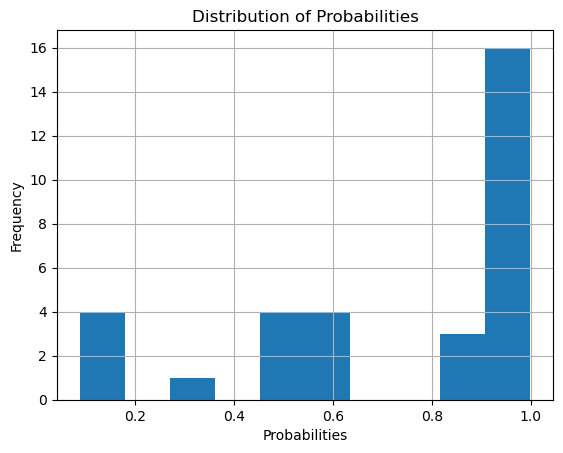

Accuracy for Predicting Round 1 is: 0.75


In [1019]:
model_xgb_prediction_pd['XGB_Probabilities'].hist(bins = 10)
plt.xlabel("Probabilities")
plt.ylabel("Frequency")
plt.title("Distribution of Probabilities")
plt.show()
model_xgb_accuracy_tournament = len(model_xgb_prediction_pd[model_xgb_prediction_pd['XGB_Probabilities'] >= .5]) / 32
print("Accuracy for Predicting Round 1 is:", model_xgb_accuracy_tournament)

In [1020]:
print("Gonzaga vs. Georgia St. Prediction:", model_xgb_prediction_pd.iloc[3, 2])
print("UCLA vs. Akron Prediction:", model_xgb_prediction_pd.iloc[15, 2])
print("North Carolina vs. Marquette:", model_xgb_prediction_pd.iloc[9, 2])
print("Notre Dame vs. Alabama:", model_xgb_prediction_pd.iloc[24, 2])
print("St. Peter's vs. Kentucky:", model_xgb_prediction_pd.iloc[13, 2])

Gonzaga vs. Georgia St. Prediction: 0.98473674
UCLA vs. Akron Prediction: 0.9853607
North Carolina vs. Marquette: 0.47195742
Notre Dame vs. Alabama: 0.46739092
St. Peter's vs. Kentucky: 0.8772055


In [1021]:
results.append({'Name': 'XGB',
                'Training_Acc': model_xgb_accuracy, 
                'Tournament_Acc': model_xgb_accuracy_tournament
               })

Very, very interesting. Although it only predict 3 games correctly, we see that it correctly predicted St. Peter's victory; however, it was not able to predict Notre Dame winning and even worse North Carolina (a finalist in the tournament). Different does not always mean better, but it does show that a lower training accuracy does not mean a lower tournament accuracy.

In [1022]:
results

[{'Name': 'Linear_SVC', 'Training_Acc': 0.742, 'Tournament_Acc': 0.75},
 {'Name': 'Radial_SVC', 'Training_Acc': 0.7451, 'Tournament_Acc': 0.6875},
 {'Name': 'Degree3_SVC', 'Training_Acc': 0.7451, 'Tournament_Acc': 0.6875},
 {'Name': 'Logistic_Regression',
  'Training_Acc': 0.7487684729064039,
  'Tournament_Acc': 0.75},
 {'Name': 'Logistic_Regression_HTuned',
  'Training_Acc': 0.7438423645320197,
  'Tournament_Acc': 0.65625},
 {'Name': 'KNN242',
  'Training_Acc': 0.7475369458128078,
  'Tournament_Acc': 0.59375},
 {'Name': 'KNN_Best',
  'Training_Acc': 0.7438423645320197,
  'Tournament_Acc': 0.59375},
 {'Name': 'KNN_Best',
  'Training_Acc': 0.7438423645320197,
  'Tournament_Acc': 0.59375},
 {'Name': 'XGB', 'Training_Acc': 0.6988916256157636, 'Tournament_Acc': 0.75}]

## Conclusion

After examining a couple of models (and their slight derivatives), I have come to the conclusion that a **Logistic Regression** model would suffice. Although it is the most basic one, it was the only one to have both a respectabe training accuracy and a tournament accuracy.

If not Logistic Regression, I would choose the Radial SVC. The only problem what that (and all SVC's) is the runtime. When I scale this to include all 38 seasons plus the training set for 2023, say goodbye to my i5 processor.

XGBoost did a really good job predicting those upsets as we can see with the lower training accuracy and a higher tournament accuracy. Two problems arise here. If it is upset heavy, then we would have an awful bracket. Sure we willg get the upsets, but the goal is to select the upsets carefully. If it got lucky and picked soley St. Peter's to be a huge upset, how will we know it will predict Princeton (2023) to upset Arizona?

Lastly and certainly the least, KNN did a very good job in the training set, but like Purdue in the past 3 years, crumbles under the pressure. It seems like it does not take in to account the seed feature well. 